In [ ]:
import pandas as pd
import cv2
import numpy as np
from tqdm import trange
from glob import glob
from pathlib import Path
from decord import VideoReader

video_dir = Path("/mnt/upramdya/data/TL/ball_pushing/ExR1(EB)")
video_paths = sorted(video_dir.glob("20250714-150800-1747518*.mp4"))
data_dir = Path("data")
xy = np.array([
    pd.read_parquet(data_dir / f"{i.stem}.parquet")[["x", "y"]].values.reshape((6, -1, 2))
    for i in video_paths
])
xy = xy.transpose((2, 0, 1, 3))
# final shape (n_frames, n_cameras=2, n_corridors=6, |{x,y}|=2)

In [2]:
# reverse the corridors for the bottom camera because the
# corridors are ordered from top to bottom in image space
xy[:, 0] = xy[:, 0, ::-1]

# flip the y-coordinates for the bottom camera
xy[:, 0, :, 1] = 2048 - xy[:, 0, :, 1]

In [3]:
M, mask = cv2.findHomography(
    xy[:, 0].astype(np.float32).reshape((-1, 2)),
    xy[:, -1].astype(np.float32).reshape((-1, 2)),
    cv2.RANSAC, 5.0
)

In [4]:
i_frame = 1000

In [5]:
frames = [VideoReader(i.as_posix())[i_frame].asnumpy()[..., 0] for i in video_paths]
frames[0] = frames[0]

In [6]:
import numpy as np
from skimage import color

def combine_two_grayscale_images(img1, img2):
    """
    Combine two single-channel 8-bit images into one RGB 8-bit image
    using perceptually orthogonal colors in CIE Lab space.

    Parameters
    ----------
    img1, img2 : ndarray
        Single-channel uint8 images of the same shape.

    Returns
    -------
    rgb_img : ndarray
        RGB uint8 image of the same height and width.
    """

    # Normalize to 0–1
    img1_norm = img1.astype(np.float32) / 255.0
    img2_norm = img2.astype(np.float32) / 255.0

    # Pick two perceptually orthogonal colors in Lab with equal L
    # Let's pick:
    #   A = vivid red (Lab: L=60, a=70, b=40)
    #   B = vivid green (Lab: L=60, a=-70, b=40)
    # These are not exact "perfect orthogonal vectors" in perception,
    # but they're close and balanced in brightness.
    L_black = 0.0
    L_target = 60.0

    # convert "#00B7EB" to lab
    from matplotlib.colors import to_rgb
    colorA_lab = color.rgb2lab(to_rgb("#00B7EB"))
    colorB_lab = color.rgb2lab(to_rgb("#E6007E"))

    # colorA_lab = np.array([L_target, 70, 40])
    # colorB_lab = np.array([L_target, -70, 40])
    black_lab = np.array([L_black, 0, 0])

    # Create colormaps in Lab from black to colorA and black to colorB
    img1_lab = black_lab + (colorA_lab - black_lab) * img1_norm[..., None]
    img2_lab = black_lab + (colorB_lab - black_lab) * img2_norm[..., None]

    # Blend (additive in Lab space)
    blended_lab = img1_lab + img2_lab
    # Clip L to [0, 100], a/b to a reasonable range
    blended_lab[..., 0] = np.clip(blended_lab[..., 0], 0, 100)

    # Convert Lab to RGB
    blended_rgb = color.lab2rgb(blended_lab)

    # Convert to uint8
    blended_rgb_uint8 = np.clip(blended_rgb * 255, 0, 255).astype(np.uint8)

    return blended_rgb_uint8, color.lab2rgb(img1_lab), color.lab2rgb(img2_lab)


In [7]:
im_warped = cv2.warpPerspective(
    frames[0][::-1], M, (frames[1].shape[1], frames[1].shape[0])
)
im_combined, im0to1, im1 = combine_two_grayscale_images(im_warped, frames[1])
_, im0, _ = combine_two_grayscale_images(frames[0], frames[1])

Text(0.5, 1.0, 'Combined')

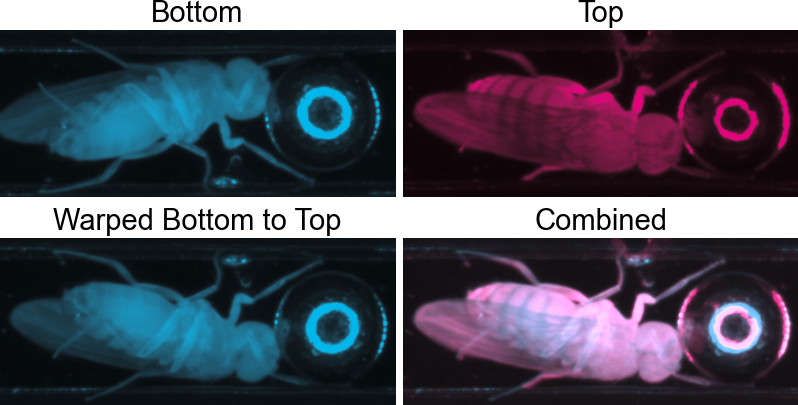

In [10]:
import matplotlib.pyplot as plt
from mplex import Grid
g = Grid(((860 - 220) / (1000 - 730) * 40, 40), (2, 2), sharex=False, sharey=False, space=(2, 10))
axs = g.axs.ravel()
axs = axs.ravel()

for ax in axs:
    ax.set_xlim(220, 860)
    ax.set_ylim(1000, 730)
    ax.axis("off")

axs[0].imshow(im0[::-1])
axs[0].invert_yaxis()
axs[1].imshow(im1)
axs[2].imshow(im0to1)
axs[3].imshow(im_combined)

axs[0].set_title("Bottom")
axs[1].set_title("Top")
axs[2].set_title("Warped Bottom to Top")
axs[3].set_title("Combined")